## Link Video
### https://drive.google.com/drive/folders/1v1En2xqdBHOVpnJODKBRemMxlZTXfk8y?usp=sharing

# **3. Data Generation using GAN (Base)**

## Import Library

In [1]:
from zipfile import ZipFile
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import cv2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input, Dense, Reshape, Conv2D, Conv2DTranspose, Activation, LeakyReLU, Flatten, MaxPooling2D, UpSampling2D, Cropping2D, BatchNormalization
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import array_to_img
from scipy.linalg import sqrtm

## Extract File (Because In Colab)

In [2]:
zip_path = '/content/B_23.zip'
extract_path = '/content/B_23'

with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

def loadFile(folder_path='/content/B_23', size=(100, 100)):
    images = []
    valid_extensions = ('.jpg', '.png', '.jpeg')

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(valid_extensions):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32) / 127.5 - 1.0
            images.append(img)

    return np.array(images)

real_images = loadFile()
print("Images loaded:", real_images.shape)

Images loaded: (0,)


## Read Data

In [3]:
def loadFile(folder_path='B_23/B_23', size=(100, 100)):
    images = []
    valid_extensions = ('.jpg', '.png', '.jpeg')

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(valid_extensions):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is None:
                continue

            img = cv2.resize(img, size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32) / 127.5 - 1.0
            images.append(img)

    return np.array(images)

In [4]:
real_images = loadFile('B_23/B_23', size=(100, 100))

## Show Image

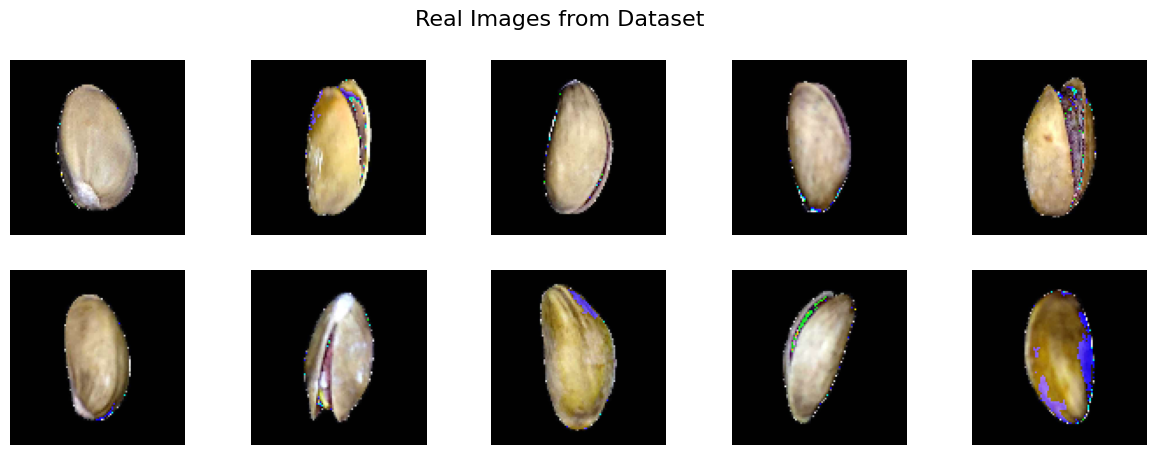

In [5]:
def plot_real_images(images, num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow((images[i] * 255).astype(np.uint8))
        plt.axis('off')
    plt.suptitle('Real Images from Dataset', fontsize=16)
    plt.show()

plot_real_images(real_images, num_images=10)

## Generator Model

In [6]:
def build_generator(noise_dim=100):
    model = Sequential()

    model.add(Dense(28 * 28 * 64, input_dim=noise_dim))
    model.add(Reshape((28, 28, 64)))

    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(64, kernel_size=3, strides=1, padding='valid'))
    model.add(Activation('relu'))

    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(32, kernel_size=3, strides=1, padding='valid'))
    model.add(Activation('relu'))

    model.add(Conv2D(16, kernel_size=3, strides=1, padding='valid'))
    model.add(Activation('relu'))

    model.add(Conv2D(3, kernel_size=3, strides=1, padding='valid'))
    model.add(Activation('tanh'))

    model.add(Cropping2D(cropping=((1, 1), (1, 1))))

    return model


## Discriminator Model

In [7]:
def build_discriminator(input_shape=(100, 100, 3)):
    model = Sequential()

    model.add(Conv2D(16, kernel_size=3, strides=1, padding='valid', input_shape=input_shape))
    model.add(Activation('relu'))

    model.add(Conv2D(32, kernel_size=3, strides=1, padding='valid'))
    model.add(Activation('relu'))

    model.add(Conv2D(64, kernel_size=3, strides=1, padding='valid'))
    model.add(Activation('relu'))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [8]:
class CustomGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.disc = discriminator
        self.gen = generator
        self.latent_dim = latent_dim

    def compile(self, disc_optimizer, gen_optimizer, loss_function):
        super().compile()
        self.d_opt = disc_optimizer
        self.g_opt = gen_optimizer
        self.loss_fn = loss_function
        self.d_loss_tracker = tf.keras.metrics.Mean(name="disc_loss")
        self.g_loss_tracker = tf.keras.metrics.Mean(name="gen_loss")

    @property
    def metrics(self):
        return [self.d_loss_tracker, self.g_loss_tracker]

    def train_step(self, real_data):
        batch_size = tf.shape(real_data)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        with tf.GradientTape() as tape:
            generated = self.gen(noise, training=True)
            real_pred = self.disc(real_data, training=True)
            fake_pred = self.disc(generated, training=True)
            d_loss_real = self.loss_fn(tf.ones_like(real_pred), real_pred)
            d_loss_fake = self.loss_fn(tf.zeros_like(fake_pred), fake_pred)
            d_loss = d_loss_real + d_loss_fake
        disc_grads = tape.gradient(d_loss, self.disc.trainable_weights)
        self.d_opt.apply_gradients(zip(disc_grads, self.disc.trainable_weights))

        noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            gen_imgs = self.gen(noise, training=True)
            disc_pred = self.disc(gen_imgs, training=True)
            g_loss = self.loss_fn(tf.ones_like(disc_pred), disc_pred)
        gen_grads = tape.gradient(g_loss, self.gen.trainable_weights)
        self.g_opt.apply_gradients(zip(gen_grads, self.gen.trainable_weights))

        self.d_loss_tracker.update_state(d_loss)
        self.g_loss_tracker.update_state(g_loss)

        return {
            "disc_loss": self.d_loss_tracker.result(),
            "gen_loss": self.g_loss_tracker.result(),
        }

In [9]:
class GANSnapshotCallback(tf.keras.callbacks.Callback):
    def __init__(self, num_samples=5, latent_dim=100, save_every=10):
        super().__init__()
        self.num_samples = num_samples
        self.latent_dim = latent_dim
        self.save_every = save_every
        self.fixed_noise = tf.random.normal([self.num_samples, self.latent_dim])

        self.g_losses = []
        self.d_losses = []

        self.output_dir = "epoch_generated_images"
        os.makedirs(self.output_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        self.d_losses.append(logs.get('d_loss'))
        self.g_losses.append(logs.get('g_loss'))

        if (epoch + 1) % self.save_every == 0:
            fake_images = self.model.gen(self.fixed_noise, training=False)
            fake_images = (fake_images + 1.0) / 2.0

            fig, axes = plt.subplots(1, self.num_samples, figsize=(15, 3))
            fig.suptitle(f"Generated Samples at Epoch {epoch + 1}", fontsize=14)

            for i in range(self.num_samples):
                axes[i].imshow(fake_images[i])
                axes[i].axis('off')

            plt.show()
            plt.close()

## Build Model

In [10]:
noise_dim = 100

generator = build_generator()
discriminator = build_discriminator()

gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

gan = CustomGAN(discriminator, generator, latent_dim=noise_dim)

gan.compile(
    disc_optimizer=disc_optimizer,
    gen_optimizer=gen_optimizer,
    loss_function=tf.keras.losses.BinaryCrossentropy()
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Preprocess Image

In [11]:
real_images = loadFile('B_23/B_23', size=(100, 100))
print(real_images.shape)

(1074, 100, 100, 3)


Epoch 1/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 35s 960ms/step - disc_loss: 0.8103 - gen_loss: 0.8040
Epoch 2/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 165ms/step - disc_loss: 0.5355 - gen_loss: 0.9734
Epoch 3/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - disc_loss: 0.1090 - gen_loss: 2.7746
Epoch 4/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - disc_loss: 0.0205 - gen_loss: 4.4790
Epoch 5/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - disc_loss: 0.1425 - gen_loss: 4.4120
Epoch 6/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - disc_loss: 0.0743 - gen_loss: 4.6634
Epoch 7/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - disc_loss: 0.4806 - gen_loss: 4.3382
Epoch 8/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - disc_loss: 3.1418 - gen_loss: 1.0501
Epoch 9/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - disc_loss: 1.5512 - gen_loss: 2.4403
Epoch 10/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - disc_loss: 0.7748 - gen_loss: 2.6359
Epoch 11/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - disc_loss: 0.6548 - g

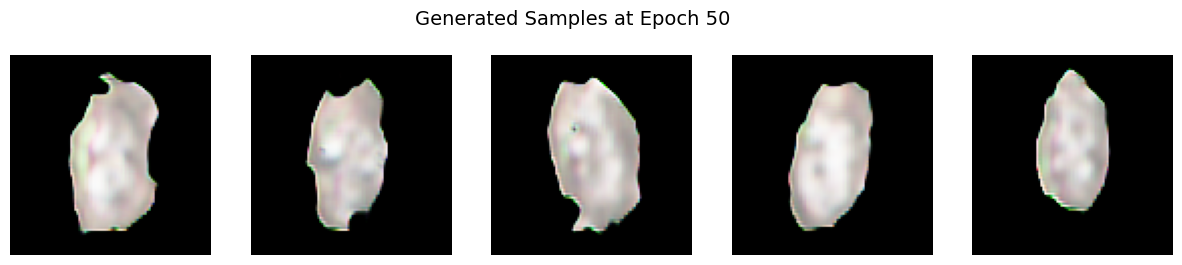

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 205ms/step - disc_loss: 0.9860 - gen_loss: 1.2627
Epoch 51/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - disc_loss: 1.2272 - gen_loss: 1.1127
Epoch 52/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - disc_loss: 1.1750 - gen_loss: 1.1429
Epoch 53/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - disc_loss: 0.8957 - gen_loss: 1.1868
Epoch 54/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - disc_loss: 1.0103 - gen_loss: 1.1774
Epoch 55/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - disc_loss: 1.2481 - gen_loss: 0.9276
Epoch 56/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - disc_loss: 1.0609 - gen_loss: 1.0838
Epoch 57/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - disc_loss: 0.9174 - gen_loss: 1.2007
Epoch 58/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - disc_loss: 1.0641 - gen_loss: 1.1458
Epoch 59/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - disc_loss: 0.9241 - gen_loss: 1.2902
Epoch 60/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - disc_loss: 1.1021 - gen_los

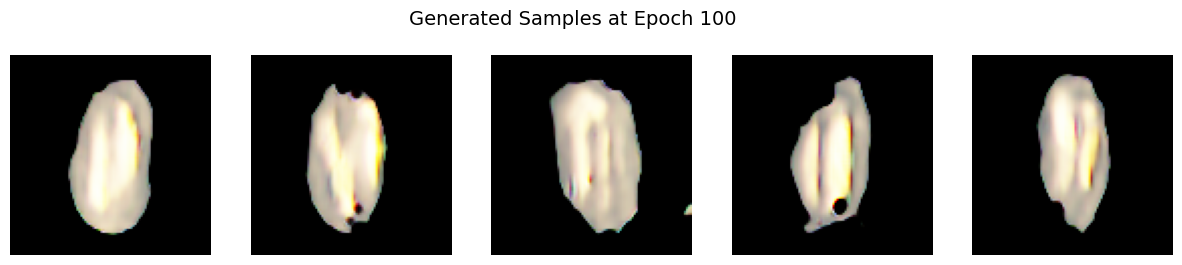

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - disc_loss: 1.0001 - gen_loss: 1.0955
Epoch 101/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - disc_loss: 1.1053 - gen_loss: 1.0518
Epoch 102/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - disc_loss: 1.0995 - gen_loss: 1.1085
Epoch 103/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - disc_loss: 1.0218 - gen_loss: 1.1311
Epoch 104/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - disc_loss: 1.1533 - gen_loss: 0.9567
Epoch 105/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - disc_loss: 1.1269 - gen_loss: 0.9921
Epoch 106/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - disc_loss: 1.0436 - gen_loss: 1.0793
Epoch 107/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - disc_loss: 1.5267 - gen_loss: 0.8623
Epoch 108/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - disc_loss: 1.1888 - gen_loss: 1.0053
Epoch 109/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - disc_loss: 1.0382 - gen_loss: 1.0943
Epoch 110/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - disc_loss: 1.4248

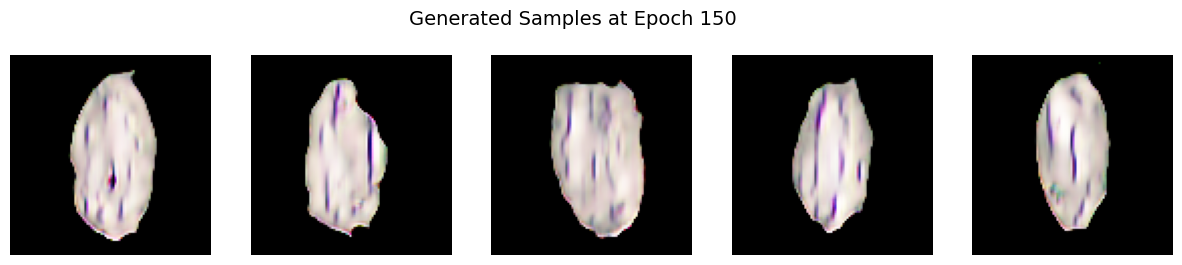

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - disc_loss: 0.9765 - gen_loss: 1.3031
Epoch 151/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - disc_loss: 1.1579 - gen_loss: 1.2301
Epoch 152/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - disc_loss: 1.4017 - gen_loss: 0.8856
Epoch 153/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - disc_loss: 1.5932 - gen_loss: 0.8743
Epoch 154/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - disc_loss: 0.9940 - gen_loss: 1.0671
Epoch 155/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - disc_loss: 0.7298 - gen_loss: 1.4586
Epoch 156/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - disc_loss: 1.5030 - gen_loss: 0.9080
Epoch 157/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - disc_loss: 1.5258 - gen_loss: 0.7875
Epoch 158/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - disc_loss: 0.9271 - gen_loss: 1.2157
Epoch 159/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - disc_loss: 0.9990 - gen_loss: 1.1396
Epoch 160/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - disc_loss: 1.1297

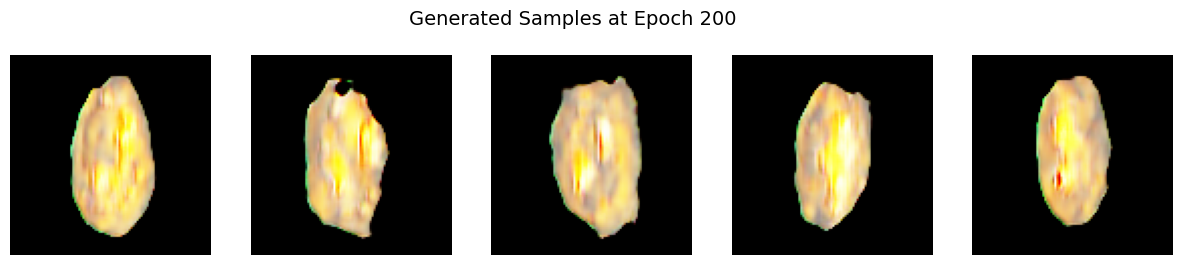

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - disc_loss: 1.3551 - gen_loss: 1.3360
Epoch 201/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - disc_loss: 0.4502 - gen_loss: 2.0600
Epoch 202/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - disc_loss: 1.4572 - gen_loss: 0.8639
Epoch 203/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - disc_loss: 1.0283 - gen_loss: 1.1124
Epoch 204/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - disc_loss: 1.2623 - gen_loss: 1.0703
Epoch 205/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - disc_loss: 1.2984 - gen_loss: 0.8491
Epoch 206/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - disc_loss: 0.8629 - gen_loss: 1.1984
Epoch 207/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - disc_loss: 0.8024 - gen_loss: 1.2436
Epoch 208/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - disc_loss: 1.1714 - gen_loss: 1.0295
Epoch 209/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - disc_loss: 0.9897 - gen_loss: 1.2728
Epoch 210/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - disc_loss: 0.7730

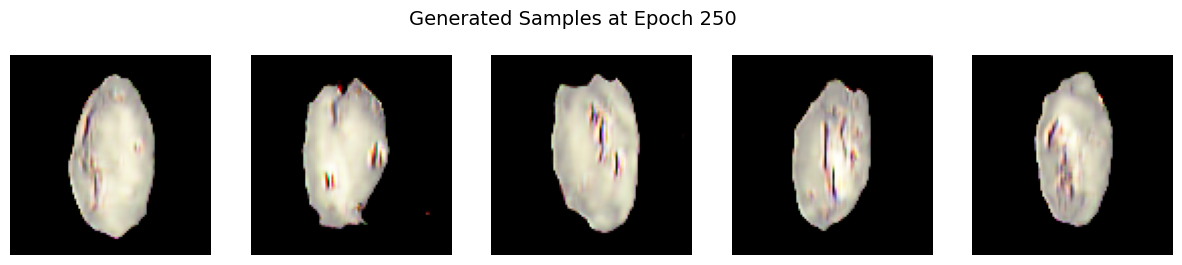

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - disc_loss: 0.8021 - gen_loss: 1.4349
Epoch 251/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - disc_loss: 1.0027 - gen_loss: 1.2954
Epoch 252/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - disc_loss: 1.2231 - gen_loss: 1.0254
Epoch 253/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - disc_loss: 0.9312 - gen_loss: 1.3311
Epoch 254/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - disc_loss: 0.7459 - gen_loss: 1.4222
Epoch 255/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - disc_loss: 1.1987 - gen_loss: 1.0054
Epoch 256/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - disc_loss: 1.5599 - gen_loss: 0.7468
Epoch 257/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - disc_loss: 0.9698 - gen_loss: 1.1285
Epoch 258/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - disc_loss: 0.7689 - gen_loss: 1.2874
Epoch 259/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - disc_loss: 0.8813 - gen_loss: 1.2185
Epoch 260/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - disc_loss: 1.1969

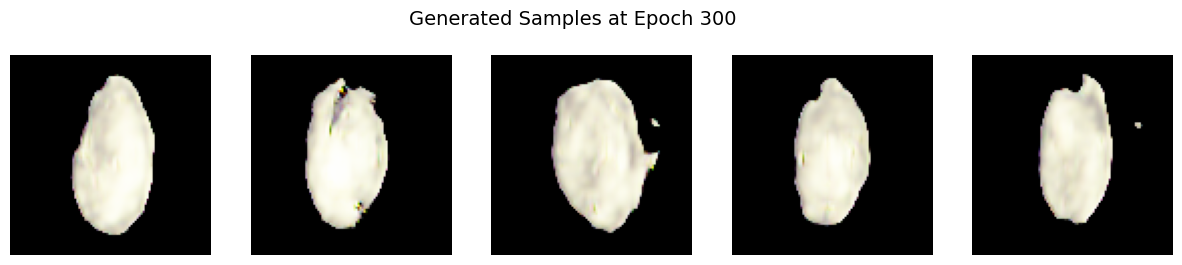

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - disc_loss: 0.8086 - gen_loss: 1.4245
Epoch 301/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - disc_loss: 0.9821 - gen_loss: 1.4162
Epoch 302/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - disc_loss: 0.6791 - gen_loss: 1.7073
Epoch 303/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - disc_loss: 0.7070 - gen_loss: 1.7045
Epoch 304/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - disc_loss: 1.1899 - gen_loss: 1.3024
Epoch 305/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - disc_loss: 0.9458 - gen_loss: 1.5306
Epoch 306/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - disc_loss: 0.6671 - gen_loss: 1.7913
Epoch 307/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - disc_loss: 1.2370 - gen_loss: 1.0780
Epoch 308/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - disc_loss: 1.1467 - gen_loss: 1.1025
Epoch 309/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - disc_loss: 0.7834 - gen_loss: 1.4149
Epoch 310/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - disc_loss: 1.0593

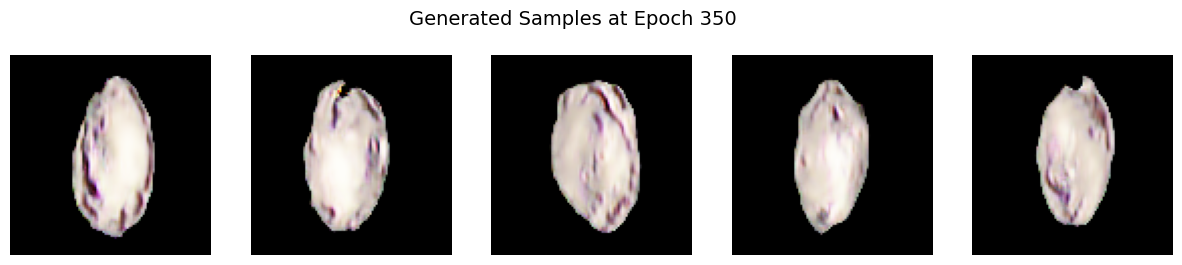

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - disc_loss: 1.0495 - gen_loss: 1.0670
Epoch 351/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - disc_loss: 1.0185 - gen_loss: 1.0944
Epoch 352/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - disc_loss: 0.9602 - gen_loss: 1.1749
Epoch 353/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - disc_loss: 1.0760 - gen_loss: 0.9779
Epoch 354/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - disc_loss: 1.0181 - gen_loss: 1.0500
Epoch 355/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - disc_loss: 0.9499 - gen_loss: 1.0907
Epoch 356/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - disc_loss: 0.9192 - gen_loss: 1.1428
Epoch 357/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - disc_loss: 1.0208 - gen_loss: 1.0684
Epoch 358/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - disc_loss: 1.1548 - gen_loss: 1.0430
Epoch 359/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - disc_loss: 0.8173 - gen_loss: 1.4319
Epoch 360/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - disc_loss: 1.1120

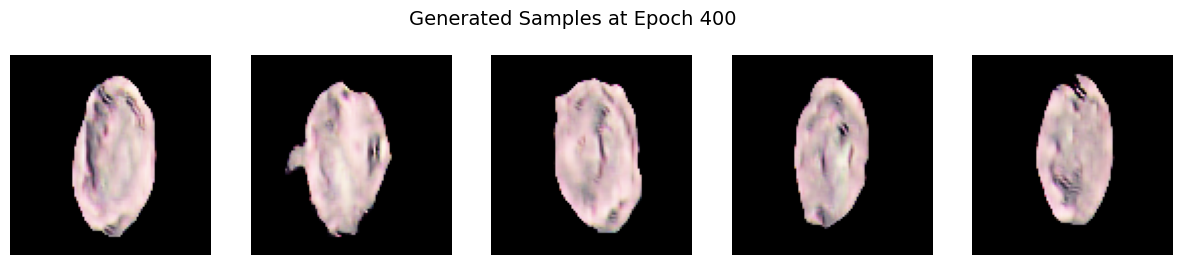

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - disc_loss: 0.5727 - gen_loss: 1.7653
Epoch 401/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - disc_loss: 0.7450 - gen_loss: 1.8156
Epoch 402/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - disc_loss: 0.2469 - gen_loss: 3.1066
Epoch 403/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - disc_loss: 0.7145 - gen_loss: 2.9090
Epoch 404/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - disc_loss: 1.5653 - gen_loss: 1.0698
Epoch 405/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - disc_loss: 0.6769 - gen_loss: 1.5088
Epoch 406/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - disc_loss: 0.4451 - gen_loss: 1.7779
Epoch 407/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - disc_loss: 0.4586 - gen_loss: 2.1274
Epoch 408/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - disc_loss: 1.4272 - gen_loss: 1.0162
Epoch 409/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - disc_loss: 1.0742 - gen_loss: 1.2349
Epoch 410/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - disc_loss: 0.6976

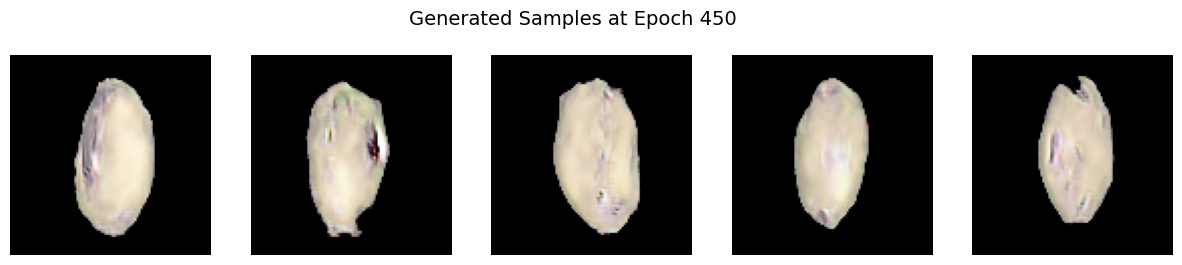

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - disc_loss: 0.8612 - gen_loss: 1.1798
Epoch 451/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - disc_loss: 0.8766 - gen_loss: 1.1777
Epoch 452/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - disc_loss: 0.9180 - gen_loss: 1.1573
Epoch 453/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - disc_loss: 0.9798 - gen_loss: 1.1474
Epoch 454/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - disc_loss: 1.0165 - gen_loss: 1.1497
Epoch 455/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - disc_loss: 0.9597 - gen_loss: 1.1315
Epoch 456/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - disc_loss: 0.9950 - gen_loss: 1.0785
Epoch 457/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - disc_loss: 0.9676 - gen_loss: 1.0802
Epoch 458/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - disc_loss: 0.9589 - gen_loss: 1.1094
Epoch 459/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - disc_loss: 0.9195 - gen_loss: 1.1632
Epoch 460/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - disc_loss: 0.8865

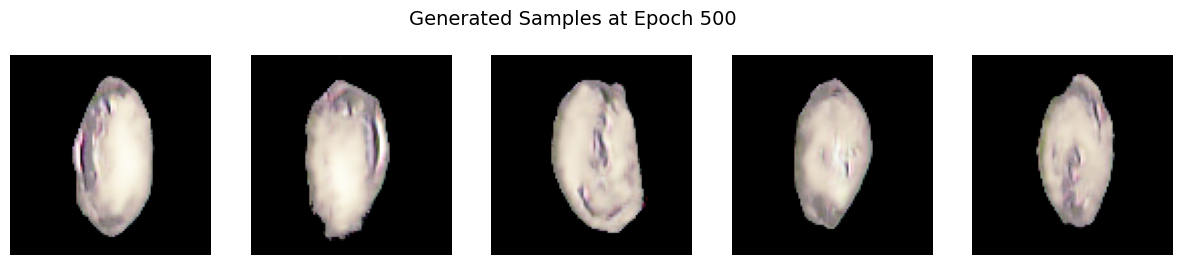

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - disc_loss: 0.8915 - gen_loss: 1.3504


In [12]:
monitor = GANSnapshotCallback(num_samples=5, latent_dim=noise_dim, save_every=50)

gan.fit(
    real_images,
    epochs=500,
    batch_size=64,
    callbacks=[monitor]
)

## Evaluate Base Model

In [13]:
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

def calculate_fid(model, real_images, fake_images):
    real_resized = np.array([cv2.resize(img, (299, 299)) for img in real_images])
    fake_resized = np.array([cv2.resize(img, (299, 299)) for img in fake_images])

    real_resized = preprocess_input(real_resized.astype(np.float32))
    fake_resized = preprocess_input(fake_resized.astype(np.float32))

    act1 = model.predict(real_resized, batch_size=32, verbose=0)
    act2 = model.predict(fake_resized, batch_size=32, verbose=0)

    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    diff = mu1 - mu2
    covmean, _ = sqrtm(sigma1 @ sigma2, disp=False)

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    return diff @ diff + np.trace(sigma1 + sigma2 - 2 * covmean)

def evaluate_baseline_fid(generator, real_images, noise_dim=100, sample_size=1000):
    real_images_sample = real_images[:sample_size].astype(np.float32)
    if real_images_sample.max() > 1.0:
        real_images_sample = real_images_sample / 255.0

    noise = np.random.normal(0, 1, (sample_size, noise_dim))
    gen_imgs = generator.predict(noise, batch_size=32, verbose=0)
    gen_imgs = 0.5 * gen_imgs + 0.5  # [-1,1] → [0,1]

    fid = calculate_fid(inception_model, real_images_sample, gen_imgs)
    print(f"FID Score (Modified Generator): {fid:.2f}")
    return fid

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
# call function evaluate
evaluate_baseline_fid(generator, real_images)

FID Score (Modified Generator): 119.59


np.float64(119.58685303360349)